In [1]:
import os
import shutil
import json
#import copy
import argparse
#import logging
import sys
from datetime import datetime
from pathlib import Path

# Hacky way to resolve project paths
sys.path.append(str(Path(os.getcwd()).parents[0]))
sys.path.append(str(Path(os.getcwd()).parents[1]))

import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 6})
#matplotlib.use('Agg')

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data import build_detection_test_loader
from detectron2.data import transforms as T
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import Boxes
from detectron2.data.datasets.coco import convert_to_coco_dict

from ubteacher.config import add_ubteacher_config
import ubteacher.utils.ROI_utils as ROI_utils
from ubteacher.engine.trainer import UBRCNNTeacherTrainer
import ubteacher.utils.utils_v1 as utils_v1

#testing

import tifffile as tf

/home/chao_lab/anaconda3/envs/AI_path/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Recreate parts of classes and functions necessary for this notebook

In [2]:
def channel_last(input: np.ndarray or tuple) -> np.ndarray or tuple:
    """Return the input in channel-last format
    Args:
    input -- np.ndarray if image or tuple of array.shape
    Return:
    image as ndarray but in channel-last (h, w, c)
    """
    if type(input) == np.ndarray:
        if input.shape[0] == 3:
            return input.transpose(1, 2, 0)
        else:
            return input
    if type(input) == tuple:
        if input[0] == 3:
            return tuple(input[i] for i in [1, 2, 0])
        else:
            return input

In [3]:
class TrainUtil:
    def __init__(self, max_dimension=1333) -> None:
        self.max_dim = max_dimension  # The max num pixels of the longest edge
        
    def find_top(self, tiff: tf.TiffFile) -> np.ndarray:
        """Return top of image pyramid under the specified resolutions; if
        embedded top level exceeds specified dimensions, will downsample.

        Args:
        tiff -- a tfffile.TiffFile image object
        """
        # GOAL: Get the highest level of image pyramid that is slightly bigger than
        # our target dimension, and resize the longest edge to target
        # Check if image pyramid is organized into levels (most files) or pages (rare)
        max_dim = self.max_dim
        top = np.array([])
            
            # Find the top of the image pyramid
        if len(tiff.series[0].levels) > 1:
            # Use levels to load
            for level_idx, level in enumerate(
                tiff.series[0].levels
            ):
                # Make sure image shape is channel-last
                level_dim = channel_last(level.shape)
                if level_dim[1] > max_dim or level_dim[2] > max_dim:
                    target_level = level_idx
                    continue
                else:
                    target_level = level_idx - 1
                    break
            top = tiff.series[0].levels[target_level].asarray()
        else:
            # Use pages to load
            for page_idx, page in enumerate(tiff.pages):
                # Make sure image shape is channel-last
                page_dim = channel_last(page.shape)
                if page_dim[1] > max_dim or page_dim[2] > max_dim:
                    target_page = page_idx
                    continue
                else:
                    target_page = page_idx - 1
                    break
            top = tiff.pages[target_page].asarray()
        # Downsample if the top is still bigger than requested
        # Make sure image array is in shape[h, w, c]
        top = channel_last(top)
        if top.shape[1] > max_dim or top.shape[2] > max_dim:
            h, w = top.shape[:2]
            longest_edge = max(h, w)
            scale_factor = round((max_dim / longest_edge), 2)
            new_h = int(h * scale_factor)
            new_w = int(w * scale_factor)
            resized = T.ResizeTransform(h, w, new_h, new_w).apply_image(top)
            return resized
        else:
            return top

In [4]:
def convert_to_coco_json(dataset_name: str, output_dir: str, allow_cached=True):
    """
    Converts dataset into COCO format and saves it to a json file.
    dataset_name must be registered in DatasetCatalog and in detectron2's standard format.

    Args:
    dataset_name -- reference from the config file to the catalogs
                    must be registered in DatasetCatalog and in detectron2's 
                    standard format
    output_file -- path of json file that will be saved to
    allow_cached -- if json file is already present then skip conversion
    """
    logger = setup_logger(name=__name__)
    coco_files = []
    for file in os.scandir(output_dir):
        if "coco" in file.name:
            coco_files.append(file.path)
    if coco_files:
        logger.info("Removing previously cached coco files...")
        for i in coco_files:
            logger.info(f"Removed {i}")
            os.remove(i)
    coco_dict = convert_to_coco_dict(dataset_name)
    coco_json = json.dumps(coco_dict, indent=4)
    coco_json_file = dataset_name + "_coco_format.json"
    print(os.path.join(output_dir, coco_json_file))
    
    with open(os.path.join(output_dir, coco_json_file), "w") as json_file:
        json_file.write(coco_json)

In [5]:
model_path_parent = '/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/output/'
#model_path_parent = '../completed_outputs/COCOPath_Pretraining_1005/'
model_path = model_path_parent + 'model_0039999.pth'
#model_path = model_path_parent + 'model_0199999.pth'
dataseed = '/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/dataseed/OSCC_TCGA_FullMix_1008.json'
dataset_dir = '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder' #Temporarily voyage because GT is not sync'd to FN
output_dir = '/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/output/test_eval'

In [6]:
# Set detection configs
print("\nSetting detection configs...")
print("Loading model...")
cfg = get_cfg()
add_ubteacher_config(cfg)
cfg.PARENTDIR = ""
cfg.DETECTION_MODE = ""
cfg.DATASEED = ""
cfg.MODEL.ROI_BOX_HEAD.BATCH_SIZE_PER_IMAGE = 4
cfg.MODEL.ROI_BOX_HEAD.NUM_CLASSES = 4
cfg.MODEL.RPN.NUM_CLASSES = 4
cfg.merge_from_file(os.path.join(model_path_parent, "config.yaml"))
cfg.MODEL.WEIGHTS = model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5


Setting detection configs...
Loading model...


In [7]:
# Load ledger from dataseed

with open(dataseed, 'r') as f:
    ledger = json.load(f)
    val_data = ledger['val']
sample_im_path = Path(val_data.get("images")[0])
source_dataset_dir = str(sample_im_path.parent.parent)

# Adjust paths for FN vs. MT

for d in val_data:
    updated_paths = [
        i.replace(source_dataset_dir, dataset_dir) for i in val_data[d]
    ]
    val_data[d] = updated_paths
print(val_data)

{'images': ['/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 23 G5_1.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 16 J19_2.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 1 J10_1.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 4 F33_3.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 12 G4_0.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 23 G7_2.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 17 F5_4.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 15 B10_2.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 14 F16_1.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 2 D4_1.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 1 J5_1.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 22 K1_2.npy', '/mnt/voyage/Da

In [8]:
# Perform registration

reg_name = 'val'
dataset_name = 'ROI_' + reg_name
print("\nRegistering dataset {}...".format(dataset_name))

# Fake a cat_map since its not currently used
cat_map = {'lesion': 0}
ROI_metadata = MetadataCatalog.get(dataset_name).set(thing_classes=['lesion'])

try:
    ROI_utils.TrainHelper().register_dataset("val", val_data, cat_map)
except:
    print("Dataset {} already registered.".format(dataset_name))
    
cfg.DATASETS.TEST = dataset_name


Registering dataset ROI_val...
working on 'ROI_val'...


In [9]:
dataloader = UBRCNNTeacherTrainer.build_test_loader(cfg, dataset_name)

[10/10 10:02:51 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/10 10:02:51 d2.data.common]: Serializing 114 elements to byte tensors and concatenating them all ...
[10/10 10:02:51 d2.data.common]: Serialized dataset takes 0.10 MiB


In [10]:
# Initialize the model
model = DefaultPredictor(cfg).model
eval_dataset = cfg.DATASETS.TEST
thing_classes = ROI_metadata.thing_classes

[10/10 10:02:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/output/model_0039999.pth ...


Some model parameters or buffers are not found in the checkpoint:
backbone.bottom_up.res2.0.conv1.norm.{bias, weight}
backbone.bottom_up.res2.0.conv1.weight
backbone.bottom_up.res2.0.conv2.norm.{bias, weight}
backbone.bottom_up.res2.0.conv2.weight
backbone.bottom_up.res2.0.conv3.norm.{bias, weight}
backbone.bottom_up.res2.0.conv3.weight
backbone.bottom_up.res2.0.shortcut.norm.{bias, weight}
backbone.bottom_up.res2.0.shortcut.weight
backbone.bottom_up.res2.1.conv1.norm.{bias, weight}
backbone.bottom_up.res2.1.conv1.weight
backbone.bottom_up.res2.1.conv2.norm.{bias, weight}
backbone.bottom_up.res2.1.conv2.weight
backbone.bottom_up.res2.1.conv3.norm.{bias, weight}
backbone.bottom_up.res2.1.conv3.weight
backbone.bottom_up.res2.2.conv1.norm.{bias, weight}
backbone.bottom_up.res2.2.conv1.weight
backbone.bottom_up.res2.2.conv2.norm.{bias, weight}
backbone.bottom_up.res2.2.conv2.weight
backbone.bottom_up.res2.2.conv3.norm.{bias, weight}
backbone.bottom_up.res2.2.conv3.weight
backbone.bottom_up

In [11]:
# Prepare coco format json

convert_to_coco_json(eval_dataset, output_dir)

print("Begin evaluation using the COCO API...")
coco_evaluator = COCOEvaluator(
    dataset_name=eval_dataset,
    tasks = ('bbox'),
    distributed=False,
    output_dir=output_dir,
    max_dets_per_image=10,
)

[10/10 10:02:55 __main__]: Removing previously cached coco files...
[10/10 10:02:55 __main__]: Removed /home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/output/test_eval/ROI_val_coco_format.json
[10/10 10:02:55 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[10/10 10:02:55 d2.data.datasets.coco]: Conversion finished, #images: 114, #annotations: 56
/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/output/test_eval/ROI_val_coco_format.json
Begin evaluation using the COCO API...
[10/10 10:02:55 d2.evaluation.coco_evaluation]: Trying to convert 'ROI_val' to COCO format ...
WARNING [10/10 10:02:55 d2.data.datasets.coco]: Using previously cached COCO format annotations at '/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/output/test_eval/ROI_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.


In [20]:
print(val_data)

{'images': ['/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 23 G5_1.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 16 J19_2.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 1 J10_1.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 4 F33_3.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 12 G4_0.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 23 G7_2.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 17 F5_4.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 15 B10_2.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 14 F16_1.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 2 D4_1.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 1 J5_1.npy', '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder/SRI_OSCC/Case 22 K1_2.npy', '/mnt/voyage/Da

In [22]:
# Perform inference with stats

predictor = DefaultPredictor(cfg)

for inputs in dataloader:
    test_img_id = inputs[0]['image_id']
    print(test_img_id)
    
    input_img = inputs[0]['image'].permute(1, 2, 0).numpy() # same as channel_last
    
    print(np.shape(input_img))
    with torch.no_grad():
        preds = predictor(input_img)
        print(type(preds))
    
    
    # Get evaluations
    coco_evaluator.process(inputs, preds)
    
coco_results = coco_evaluator.evaluate()

[10/10 10:23:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/output/model_0039999.pth ...


Some model parameters or buffers are not found in the checkpoint:
backbone.bottom_up.res2.0.conv1.norm.{bias, weight}
backbone.bottom_up.res2.0.conv1.weight
backbone.bottom_up.res2.0.conv2.norm.{bias, weight}
backbone.bottom_up.res2.0.conv2.weight
backbone.bottom_up.res2.0.conv3.norm.{bias, weight}
backbone.bottom_up.res2.0.conv3.weight
backbone.bottom_up.res2.0.shortcut.norm.{bias, weight}
backbone.bottom_up.res2.0.shortcut.weight
backbone.bottom_up.res2.1.conv1.norm.{bias, weight}
backbone.bottom_up.res2.1.conv1.weight
backbone.bottom_up.res2.1.conv2.norm.{bias, weight}
backbone.bottom_up.res2.1.conv2.weight
backbone.bottom_up.res2.1.conv3.norm.{bias, weight}
backbone.bottom_up.res2.1.conv3.weight
backbone.bottom_up.res2.2.conv1.norm.{bias, weight}
backbone.bottom_up.res2.2.conv1.weight
backbone.bottom_up.res2.2.conv2.norm.{bias, weight}
backbone.bottom_up.res2.2.conv2.weight
backbone.bottom_up.res2.2.conv3.norm.{bias, weight}
backbone.bottom_up.res2.2.conv3.weight
backbone.bottom_up

Case 23 G5_1
(2569, 1822, 3)
<class 'dict'>


TypeError: string indices must be integers

In [87]:
# testing

Case 23 G5_1
(2569, 1822, 3)


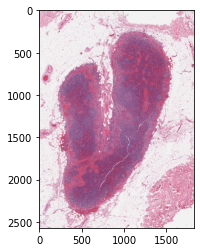

In [14]:
for inputs in dataloader:
    test_img_id = inputs[0]['image_id']
    print(test_img_id)
    img = (inputs[0]['image'].permute(1,2,0).numpy())
    print(np.shape(img))
    plt.imshow(img)
    plt.show(); plt.close()
    break

This image has 6 pages, 3 levels:
(32337, 33863, 3)
(8084, 8465, 3)
(2021, 2116, 3)


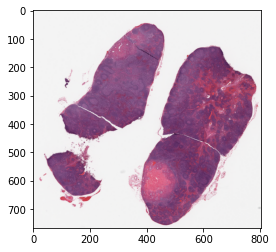

In [19]:
#src_dir = "/mnt/d/SynologyDrive/SRI_OSCC_lymph_test" # WSL
src_dir = "/mnt/FNX/SynologyDrive/Datasets_pathology/SRI_OSCC_lymph_test/" # Linux
image_id = "Case 14 F11"
image_ext = ".svs"
image_file = os.path.join(src_dir, image_id+image_ext)
max_dim = 800
# Read WSI header and get some info
with tf.TiffFile(image_file) as slide:
    print(
        f"This image has {len(slide.pages)} pages, {len(slide.series[0].levels)} levels:"
    )
    for i in slide.series[0].levels:
        print(i.shape)
    # Get image thumbnail
    image_thumbnail = TrainUtil(max_dim).find_top(slide)
    # Set image dimension attributes
    target_dim = image_thumbnail.shape
    base_dim = slide.series[0].levels[0].shape
    base_dim = channel_last(base_dim)
    # Display image
    fig, ax = plt.subplots()
    ax.imshow(image_thumbnail)
    plt.show(); plt.close()

In [20]:
with torch.no_grad():
    outputs = predictor(image_thumbnail)
instances = outputs["instances"].to('cpu')
instances.get_fields()

{'pred_boxes': Boxes(tensor([[392.0996, 524.6981, 509.1969, 678.3771]])),
 'scores': tensor([0.7561]),
 'pred_classes': tensor([0]),
 'pred_boxes_std': tensor([[-1.3245, -1.4512, -1.5773, -1.5386]])}